In [1]:
from astropy.io import fits
import numpy as np
import math as mt
import matplotlib
import matplotlib.pyplot as plt
from Statistical_functions import Mean, Covariance_M, Correlation_M, Correlation_theor, Residuals_M, Stdv, Test

In [2]:
test=[1,2,3]
TEST_COVARIANCE=True
PLOTS=True

In [3]:
Nbins=200
Nmeasures=10
measures=[list(list([]) for y in range(3)) for x in range(len(test))]

We create a single array of Nbins x Nmeasures matrices with all the multipole data (order 0, 2, 4) contained in the three parent folder (Test_1, Test_2, Test_3):

In [4]:
for j in test:
    for k in range(3):
        for i in np.arange(Nmeasures)+1:
            fname = f'/home/utente/University/AbilInfo22_23/Data/MockMeasures_2PCF_Test{j}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{j}_{i}.fits'

            file = fits.open(fname)
            table = file[1].data.copy()
            measures[j-1][k].append(table[f'XI{k*2}'])
            if i==1:
                scale = table['SCALE']
            del table
            file.close()

        measures[j-1][k]=np.asarray(measures[j-1][k]).transpose()

Now we evaluate the covariance and the normalized covariance (aka correlation matrix) from theese data:

In [5]:
Cov = []
for i in range(len(test)):
    for j in range(3):
        for k in range(3):
            if j<=k:
                Cov.append(Covariance_M(Nmeasures, Nbins, Mean(test, measures)[i][j][0], Mean(test, measures)[i][k][0], measures[i][j], measures[i][k]))
#print(len(Cov))

In [6]:
Corr = []
for i in range(len(Cov)):
    Corr.append(Correlation_M(Cov[i], Nbins))
#print(len(Corr))

Here we fix some given numerical parameters from wich we build the theoretical analogues of the covariance matrices defined above:

In [7]:
p = {'t1':[0.02, 0.02, 0.02, 25, 50, 75], 't2':[0.02, 0.01, 0.005, 50, 50, 50], 't3':[0.02, 0.01, 0.005, 5, 5, 5]}

In [8]:
Cov_th = []
for i in test:
    for j in range(3):
        for k in range(3):
            if j<=k:
                Cov_th.append(Correlation_theor(Nbins, scale, p.get(f't{i}')[j],p.get(f't{i}')[j+3], p.get(f't{i}')[k],p.get(f't{i}')[k+3]))

#print(len(Cov_th))

Then we can calculate the Residual matrices from the comparison of a measured covariance matrix and a theoretical one:

In [9]:
Res = []
for n in range(3):
    for i in range(6):
        for j in range(6):
            Res.append(Residuals_M(Cov_th[n+j], Cov[n+i], Corr[n+i], Nbins, Nmeasures))

#print(len(Res))

Here we introduce the following notation to count the six possible different 200x200 multipole cross-correlation matrices (or auto-correlation matrices if the compared multipoles are the same):

covariance matrix 0 -> auto-correlation between multipoles {0,0}

covariance matrix 1 -> cross-correlation between multipoles {0,2} (or {2,0})

covariance matrix 2 -> cross-correlation between multipoles {0,4} (or {4,0})

covariance matrix 3 -> auto-correlation between multipoles {2,2}

covariance matrix 4 -> cross-correlation between multipoles {2,4} (or {4,2})

covariance matrix 5 -> auto-correlation between multipoles {4,4}

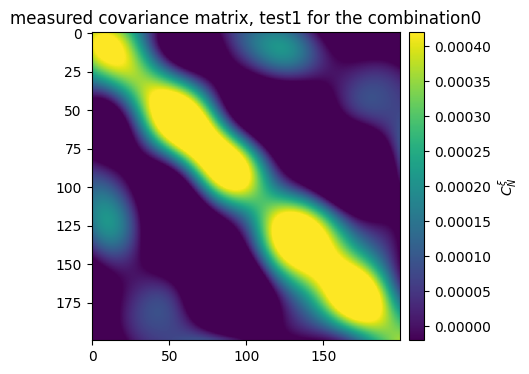

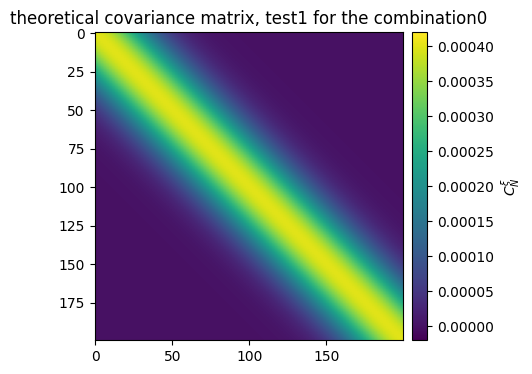

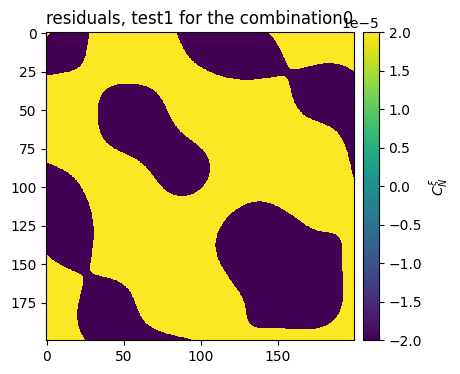

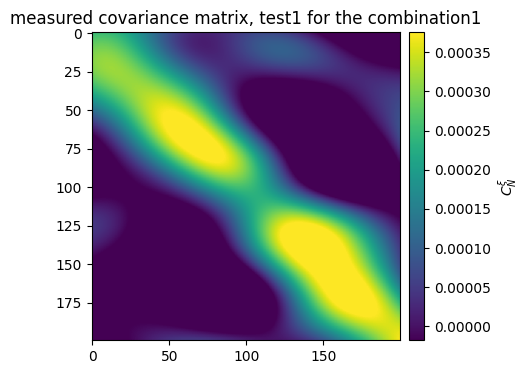

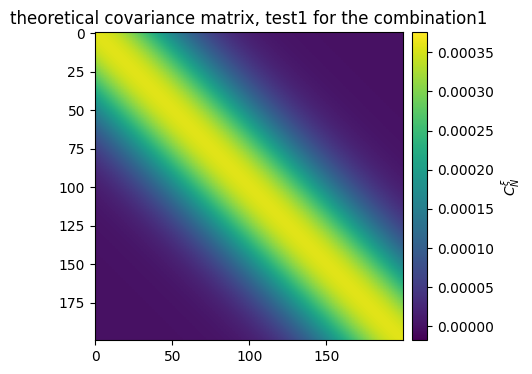

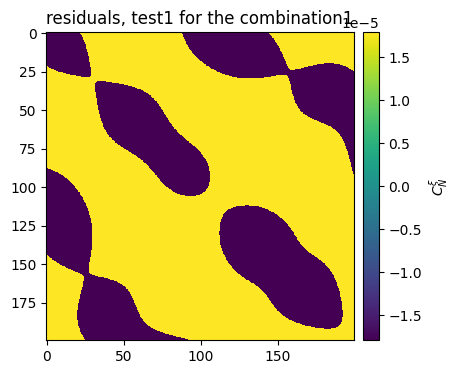

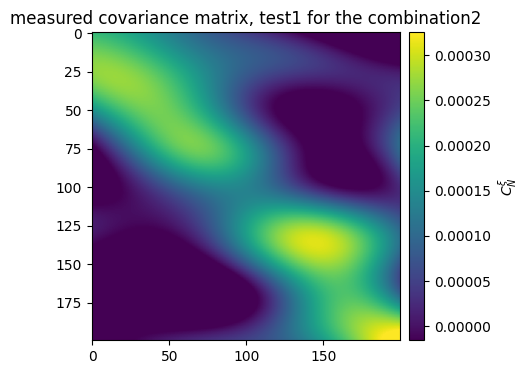

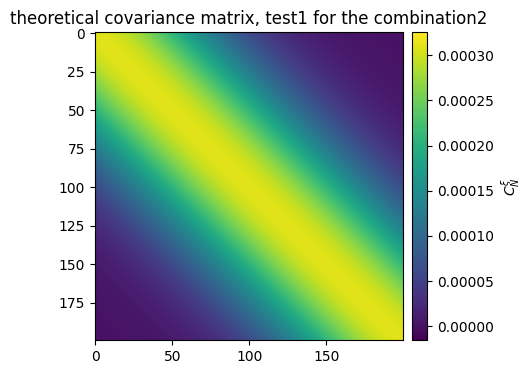

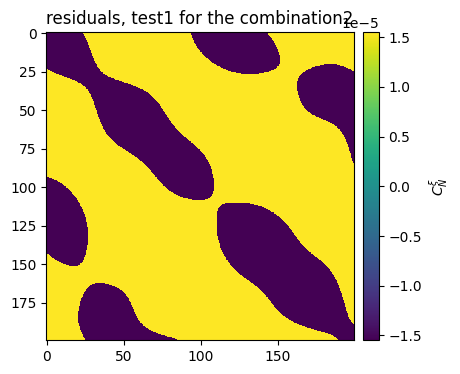

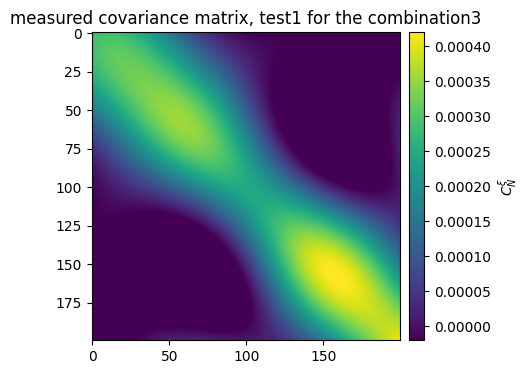

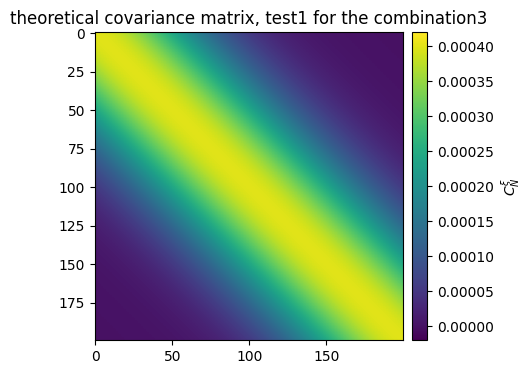

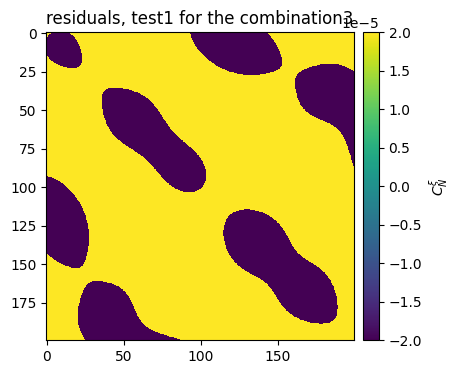

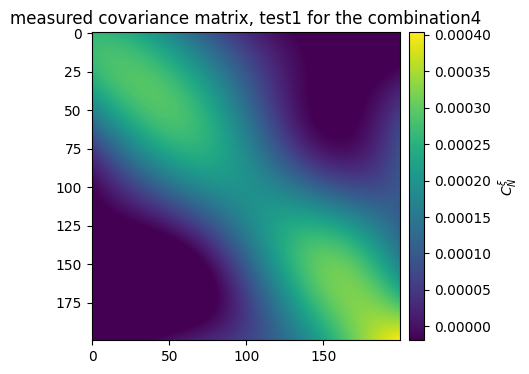

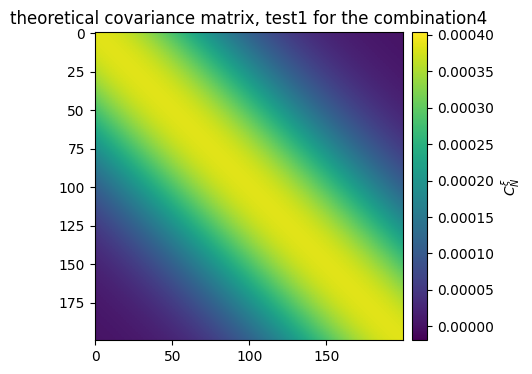

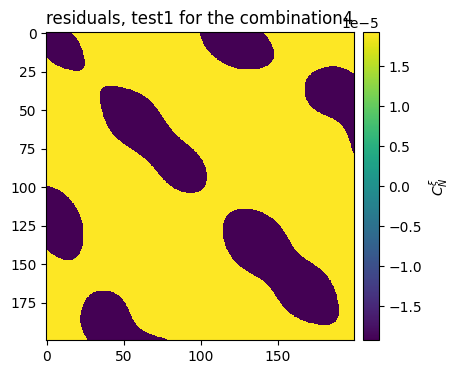

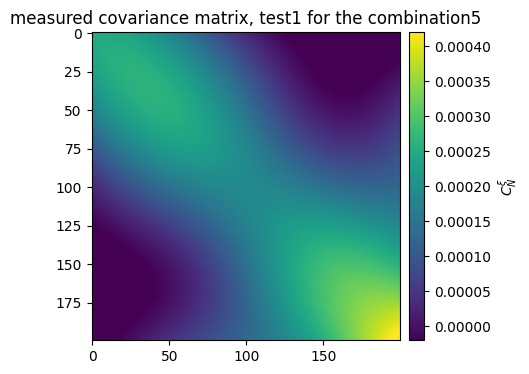

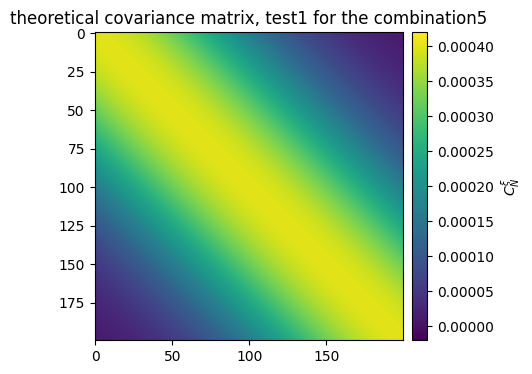

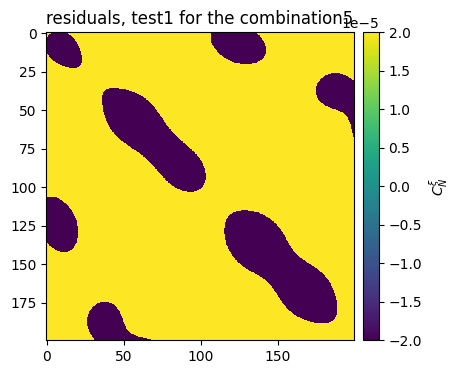

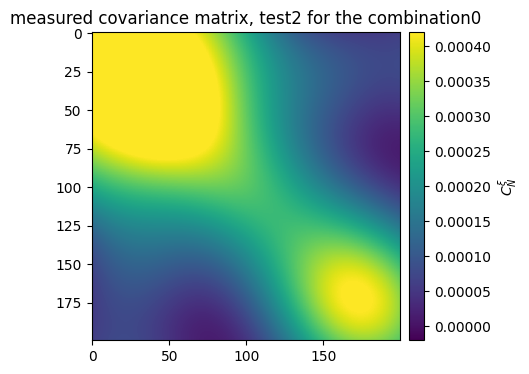

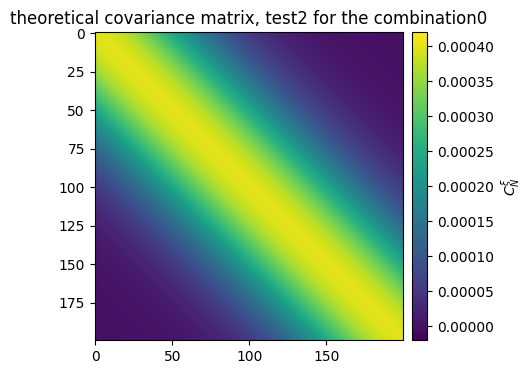

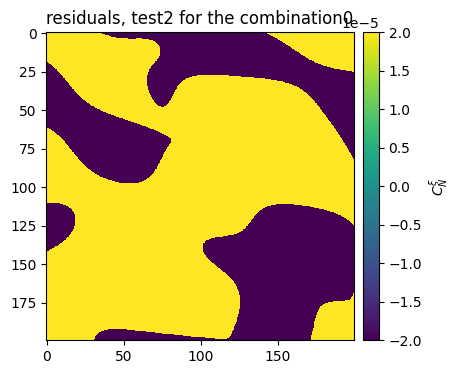

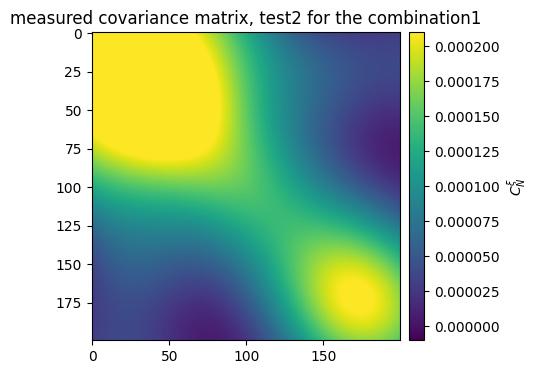

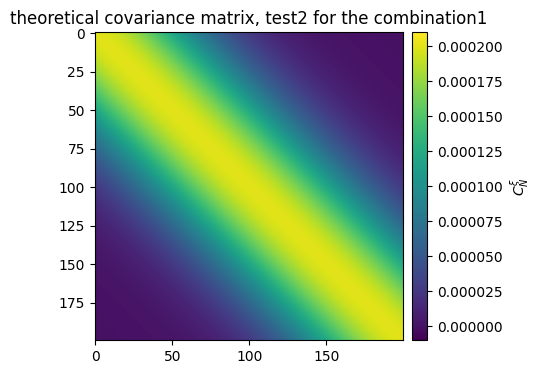

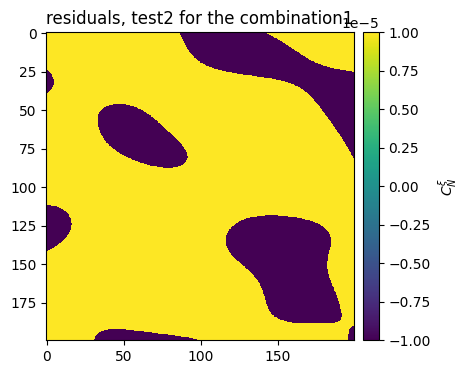

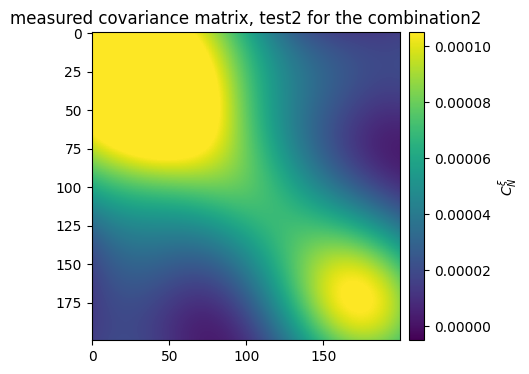

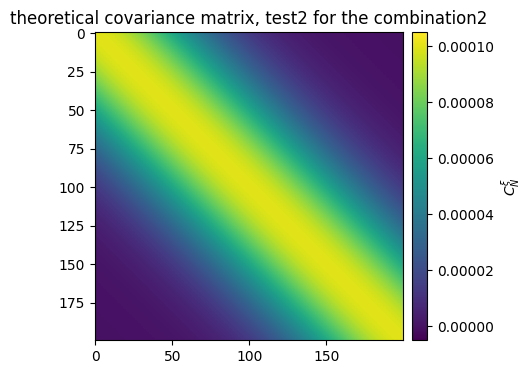

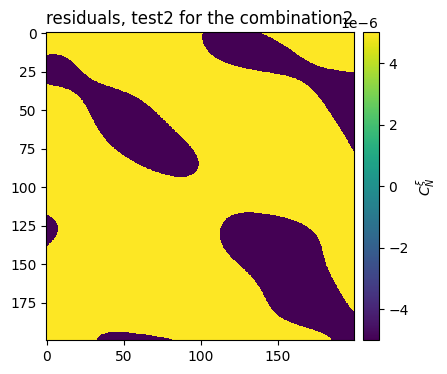

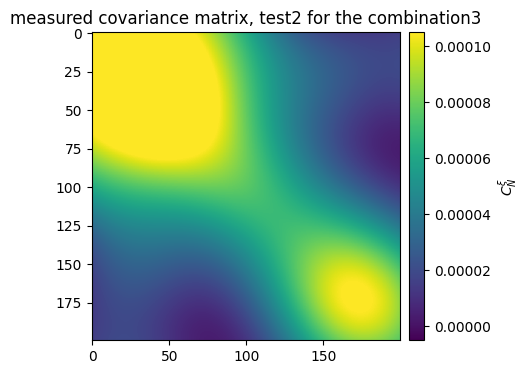

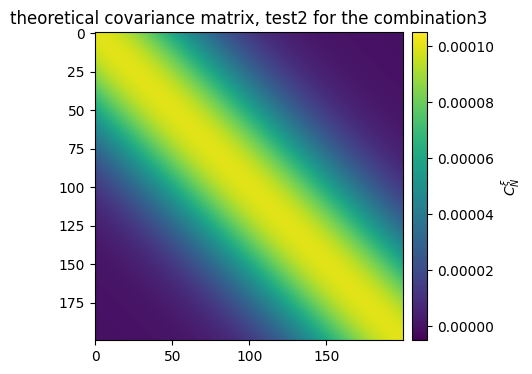

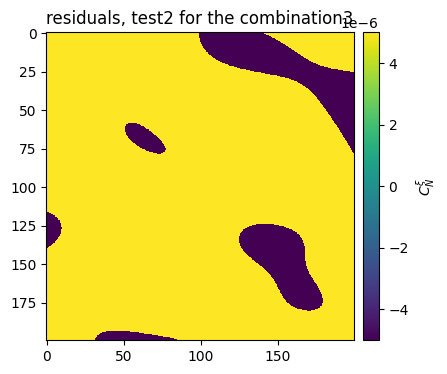

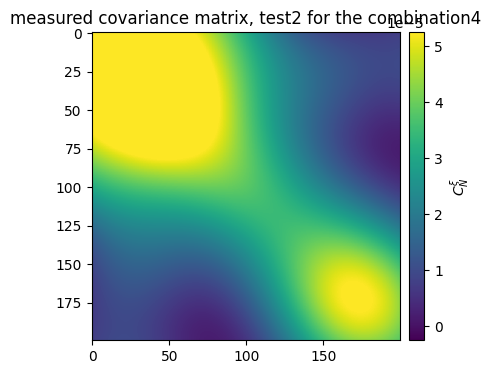

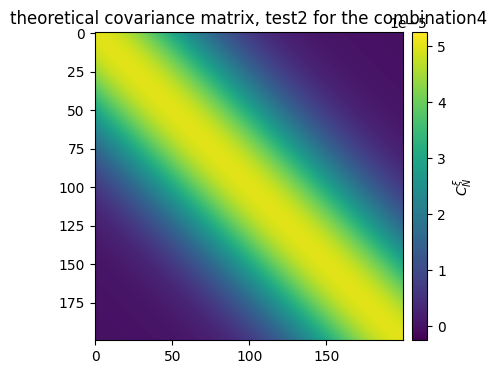

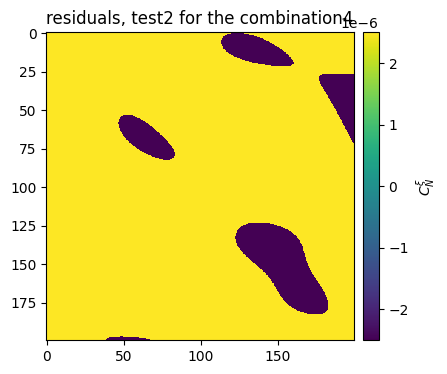

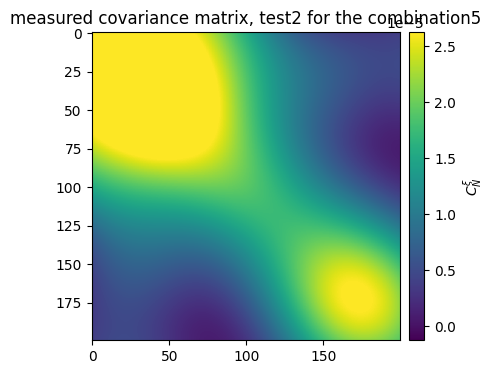

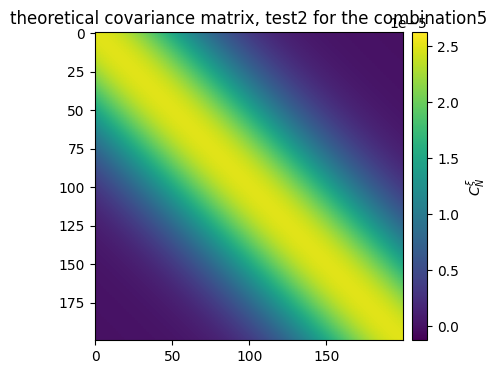

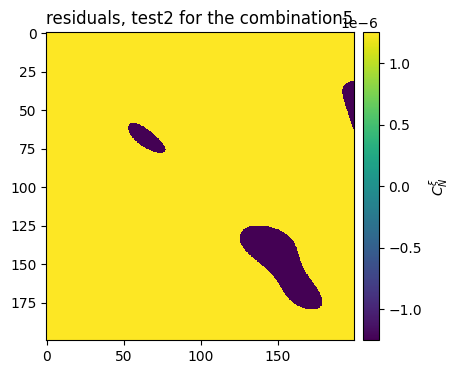

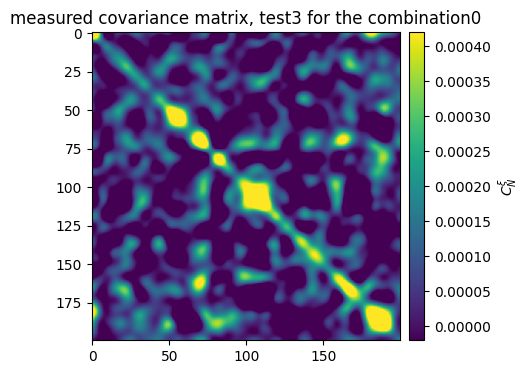

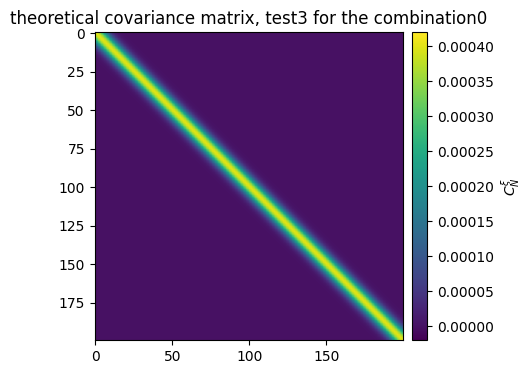

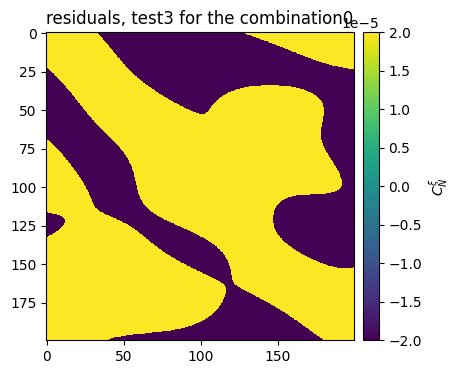

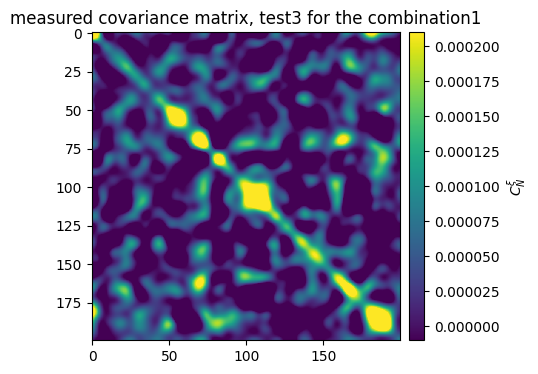

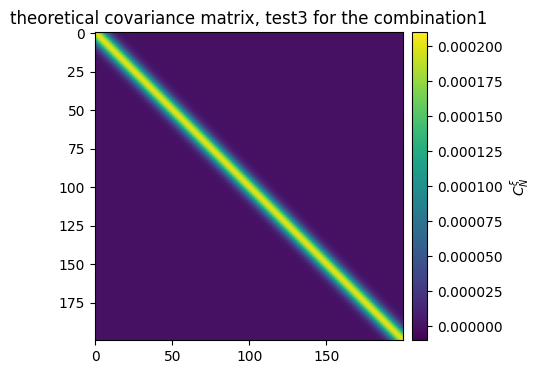

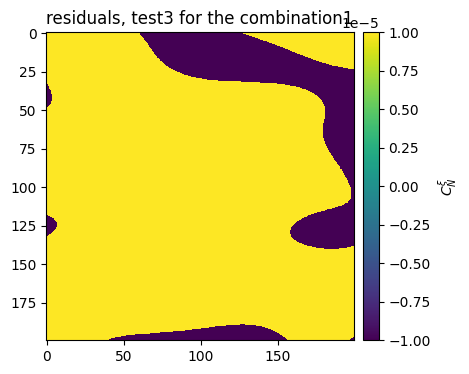

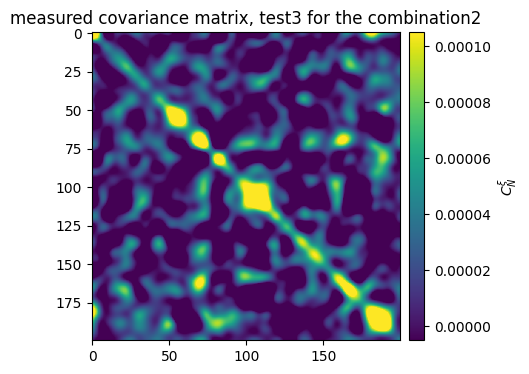

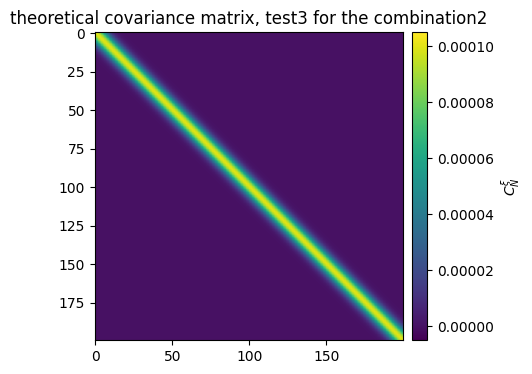

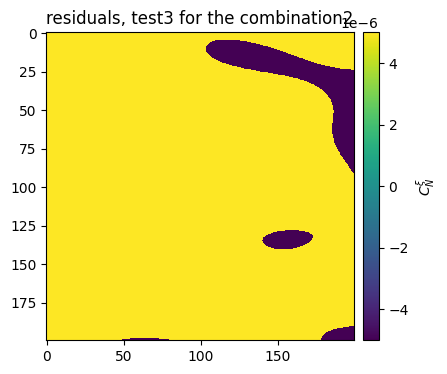

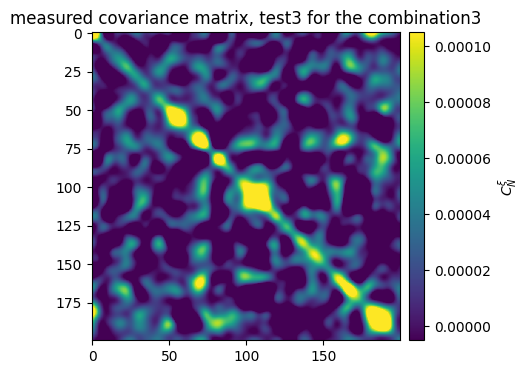

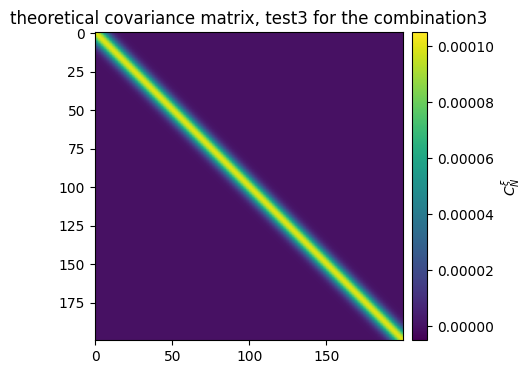

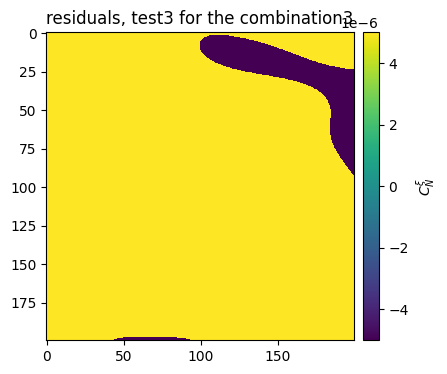

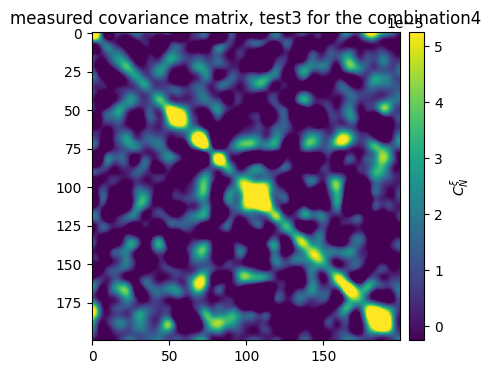

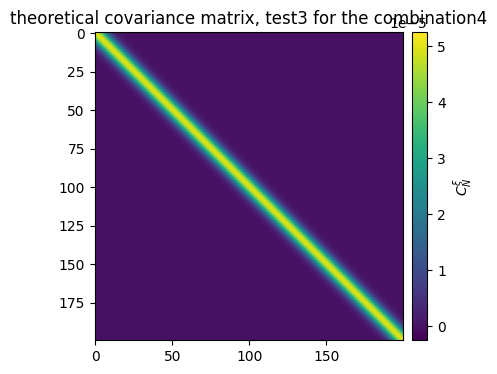

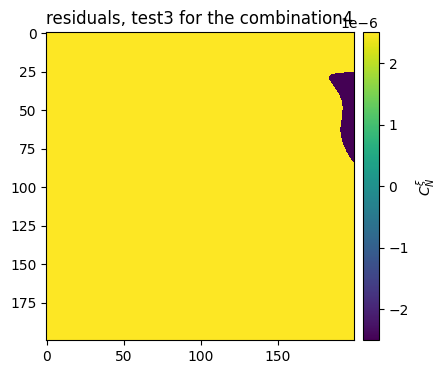

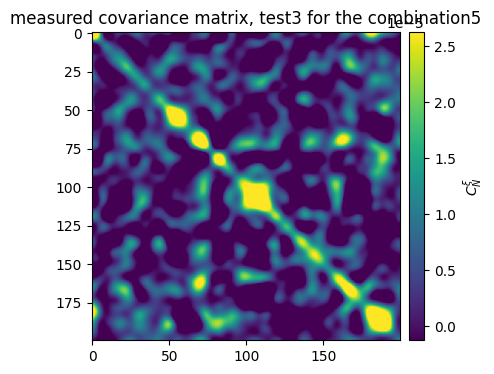

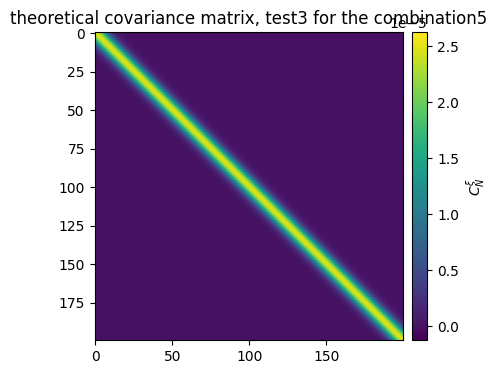

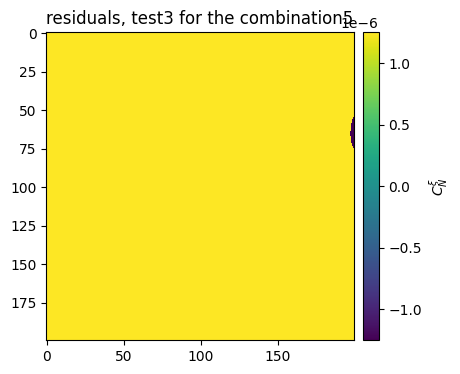

In [10]:
gratio = (1. + 5. ** 0.5) / 2.

for i in range(len(Cov)):
    
    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(Cov_th[i])*0.05
    cmax =  np.max(Cov_th[i])*1.05

    # Matrix plot of measured covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title(f'measured covariance matrix, test{i//6 + 1 } for the combination{ i - 6*(i//6) }')
    plt.imshow(Cov[i], vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()


    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title(f'theoretical covariance matrix, test{i//6 + 1 } for the combination{ i - 6*(i//6) }')
    plt.imshow(Cov_th[i], vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Matrix plot of the Residual matrix
    fig = plt.figure(figsize=(6,4))
    plt.title(f'residuals, test{i//6 + 1 } for the combination{ i - 6*(i//6) }')
    plt.imshow(Res[i], vmin=cmin, vmax=-cmin)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

We expect the residuals between the theorical and the measured covariance, properly normalized, follow a gaussian distribution with unitary standard deviation. Hence we evaluate the stdv of each of the reshaped 200x200 Res matrices and check when it is comparable with 1. 

Note that for every measured covariance matrix there are 6 possible theoretical ones it has to be compared to in order to be effectively sure only one match is allowed (i.e. 00meas <-> {00th, 02th, 04th, 22th, 24th, 44th}; 02meas <-> {00th, 02th, 04th, 22th, 24th, 44th}; ...)

In [11]:
sigma_res = np.reshape(Stdv(Res, Nbins), (18,6))
print(sigma_res)

[[1.46313784 1.92633054 2.55750736 1.94492894 2.22778295 2.27045255]
 [0.78004993 1.00626906 1.45327052 1.05995823 1.29064857 1.36101389]
 [0.5016808  0.47891697 0.64161101 0.49685773 0.59462562 0.64782598]
 [0.51286915 0.53245952 0.84657276 0.55389881 0.73999022 0.81825286]
 [0.45764498 0.33113101 0.39249158 0.29682135 0.34608401 0.3963403 ]
 [0.50481671 0.38765514 0.31627557 0.33204194 0.28038748 0.27833629]
 [1.00626906 1.45327052 1.05995823 1.29064857 1.36101389 1.05995823]
 [0.47891697 0.64161101 0.49685773 0.59462562 0.64782598 0.49685773]
 [0.53245952 0.84657276 0.55389881 0.73999022 0.81825286 0.55389881]
 [0.33113101 0.39249158 0.29682135 0.34608401 0.3963403  0.29682135]
 [0.38765514 0.31627557 0.33204194 0.28038748 0.27833629 0.33204194]
 [0.56797253 0.64755083 0.51336898 0.54143303 0.54813769 0.51336898]
 [0.64161101 0.49685773 0.59462562 0.64782598 0.49685773 0.99720057]
 [0.84657276 0.55389881 0.73999022 0.81825286 0.55389881 1.41830223]
 [0.39249158 0.29682135 0.34608401

And we conclude with a compatibility test for the covariance matrices (measured covariance vs theoretical covariance):

In [12]:
Test(sigma_res)

In the test1 the Cmeas matrix for the dipoles0 is mostly compatible with the Cth matrix for the dipoles0
In the test1 the Cmeas matrix for the dipoles1 is mostly compatible with the Cth matrix for the dipoles1
In the test1 the Cmeas matrix for the dipoles2 is mostly compatible with the Cth matrix for the dipoles5
In the test1 the Cmeas matrix for the dipoles3 is mostly compatible with the Cth matrix for the dipoles2
In the test1 the Cmeas matrix for the dipoles4 is mostly compatible with the Cth matrix for the dipoles0
In the test1 the Cmeas matrix for the dipoles5 is mostly compatible with the Cth matrix for the dipoles0
In the test2 the Cmeas matrix for the dipoles0 is mostly compatible with the Cth matrix for the dipoles0
In the test2 the Cmeas matrix for the dipoles1 is mostly compatible with the Cth matrix for the dipoles4
In the test2 the Cmeas matrix for the dipoles2 is mostly compatible with the Cth matrix for the dipoles1
In the test2 the Cmeas matrix for the dipoles3 is mostl